In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('figure', figsize=(11, 9))
plt.rc('font', size=13)

from pandas_datareader import data as web

import warnings
warnings.filterwarnings("ignore")

from ts_acquire import get_store_data, opsd_germany_daily
from ts_prepare import numeric_hists

## Time Series Data

___

### **<font color=red>What is Time Series Data?</font>**

In Time Series Data, time is the primary axis. With Time Series, the data has a natural temporal ordering and measures how things change over equally-spaced increments of time like hourly, daily, weekly, quarterly, yearly, etc. You could think of Time Series data as logs; each new measurement or log is added to the collection of previous logs. The dataset grows as new logs come in. Working with time series data can be very complicated because you are basically tracking changes over time. Sometimes the rate of change holds steady in a variable, but other times it may not. [See Heteroskedasticity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html).

___

### **<font color=orange>So What?</font>**

We have more and more apps in our lives that use Time Series Data to handle data that measures change over time. From smart thermostats to autonomous trading algorithms, time series databases are the 'fastest growing category of databases' ([source](https://blog.timescale.com/blog/what-the-heck-is-time-series-data-and-why-do-i-need-a-time-series-database-dcf3b1b18563/)).

___

### **<font color=green>Now What?</font>**

I'll start by converting my DataFrame to a DatetimeIndex.

>Importing data from a csv file as DatetimeIndex

```python
pd.read_csv(df, parse_dates=True, index_col='date').sort_index()
```

>Converting a dataframe with a string date column to one that has a DatetimeIndex.

```python
df['date'] = pd.to_datetime(df.date)

df = df.set_index('date').sort_index()
```

If you have pandas 1.0.3, read [the doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html#pandas.DatetimeIndex) on DatetimeIndex.

<hr style="border-top: 10px groove cornflowerblue; margin-top: 1px; margin-bottom: 1px"></hr>

## Acquire

<hr style="border-top: 10px groove cornflowerblue; margin-top: 1px; margin-bottom: 1px"></hr>

**<font color=green>Here I'll look at a couple example methods for acquiring some data I can use to practice working with time series methods.</font>**

### **<font color=red>What is a REST API?</font>**

Here is more than you need to know to start playing with the `requests` python library, but it still barely scratches the surface! [Here is a crash course in REST API design](https://medium.com/hashmapinc/rest-good-practices-for-api-design-881439796dc9) that helps in understanding how to use them to request data.

**API** stands for Application Programming Interface, and it is a set of rules that allows programs to talk to each other.

**JSON** stands for JavaScript Object Notation and is a text format that is language independent and made up of name/value pairs. (like a Python dictionary object or other nested sequences)

**REST** stands for **RE**presentational **S**tate **T**ransfer, which is an architectural style and approach to communications used in web service development. It can be thought of as the language of the internet.

![REST API Architecture Image](https://miro.medium.com/max/1308/1*k4EeHKe993bASHtctK-qAw.jpeg)

___

### **<font color=orange>So What?</font>**

Basically, when I link to a **specific URL, a request**, I am able to get a piece of **data returned, a response**. 

A **RESTful JSON API** uses HTTP requests to **GET (retrieve a response object)**, **PUT (change the state of or update your response object)**, **POST (create the response object)**, and **DELETE (remove a response object)** data. It allows users to connect to, manage, and interact with cloud services.

The `requests` module allows me to send HTTP requests to a REST API using python. The HTTP request to a RESTful JSON API returns a response object with the data in JSON format. I can get a variety of information from this response object using different methods, some of which are explained in the table below in 'Now What.'


**<font color=purple>Parts of a Request:</font>**

**The Endpoint or Route**

**root-endpoint** is the starting point of the API you are requesting from.

>`https://api.github.com`

**path** directs your request and determines the resource you receive as a response to your GET request. The example below gets a list of repositories by a certain user, in this case `faithkane3`. The API documentation lets me know what paths are available to me.

>`https://api.github.com/users/faithkane3/repos`

**query parameters** allow you to modify your request with key-value pairs. They begin with a `?` and are separated with `&` when you chain more than one. I am using the `sort` parameter to return my repositories in order of my most recent pushes. *This will not return any information about the repos I own or push to in other organizations besides `faithkane3`.*

>`https://api.github.com/users/faithkane3/repos?sort=pushed`

![image.jpg](https://res.cloudinary.com/indysigner/image/fetch/f_auto,q_auto/w_2000/https://cloud.netlifyusercontent.com/assets/344dbf88-fdf9-42bb-adb4-46f01eedd629/c119c0b2-4ded-42d0-90f0-496b14bf5e1f/understanding-api-doc-github-repo-opt.png)
[source](https://www.smashingmagazine.com/2018/01/understanding-using-rest-api/)

**The Method or Type of Request** CRUD (Create, Read, Update, Delete)

**GET** - A GET request performs a READ operation. A GET request to a server sends you back the data you requested.

**POST** - A POST request performs a CREATE operation. 

**PUT** - A PUT request performs an UPDATE operation.

**PATCH** - A PATCH request performs an UPDATE operation.

**DELETE** - A DELETE request performs a DELETE operation

___

### **<font color=green>Now What?</font>**

**Properties and Methods of response objects (not an exhaustive list)**

| Property/Method | Description |
| :--- | ----------- |
| .content | Returns the response in bytes |
| .json() | Returns a JSON object of the result if result in JSON format, otherwise raises an error |
|.ok|Returns True if status_code is less than 200, otherwise False|
|.request|Returns the request object that requested this response|
|.status_code|Returns a number that indicates the status|
|.text|Returns the content of the response, in unicode|
|.url|Returns the URL of the response|

___

### **Acquire a DataFrame by Making an HTTP Request**

**<font color=purple>What if I wanted to get a list of repositories from a Github user?</font>**

In [5]:
import requests

url = 'https://api.github.com/users/faithkane3/repos?sort=pushed'
response = requests.get(url)

`.ok` returns a boolean communicating if the request was successful.

In [6]:
response.ok

True

`.status_code` returns the HTTP response status code.

In [7]:
response.status_code

200

**<font color=purple>HTTP Status Codes and Error Messages</font>**

>200+ means the request has succeeded.

>300+ means the request is redirected to another URL

>400+ means an error that originates from the client has occurred

>500+ means an error that originates from the server has occurred

___

`.text` returns the raw response text

In [8]:
# I'm limiting the text string to 500 characters bc it's one long string!

print(type(response.text))
response.text[:500]

<class 'str'>


'[{"id":357610737,"node_id":"MDEwOlJlcG9zaXRvcnkzNTc2MTA3Mzc=","name":"f_python","full_name":"faithkane3/f_python","private":false,"owner":{"login":"faithkane3","id":43799876,"node_id":"MDQ6VXNlcjQzNzk5ODc2","avatar_url":"https://avatars.githubusercontent.com/u/43799876?v=4","gravatar_id":"","url":"https://api.github.com/users/faithkane3","html_url":"https://github.com/faithkane3","followers_url":"https://api.github.com/users/faithkane3/followers","following_url":"https://api.github.com/users/fai'

I can use the `.json()` method on my response and access a list of dictionaries for all my Github repos. The response will not always be a list of dictionaries; it might be a dictionary. Just make sure you know what type of structure you are working with. In this case, I find that there are 23 dictionaries in my list, `data`.

In [9]:
data = response.json()
print(type(data))
len(data)

<class 'list'>


30

In [10]:
# Access the keys of the first dictionary to understand the format of each dictionary in my list

data[0].keys()

dict_keys(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'forks_count', 'mirror_url', 'archived', 'disabled', 'open_issues_count', 'lic

In [11]:
# get a list of the names of all of my repos on Github

repos = []
for i in range(len(data)):
    repos.append(data[i]['name'])
print(repos)

['f_python', 'e_python', 'f_sql', 'flask_intro', 'e_classification', 'faithkane3', 'e_stats', 'pandas_stuff', 'e_sql', 'e_fundamentals', 'nlp', 'workshops', 'faithkane3.github.io', 'classification', 'time_series', 'python', 'regression', 'ds-methodologies-exercises', 'sql', 'pandas_practice', 'zillow_project', 'codeup_review', 'makeovermonday', 'python-exercises', 'side_projects', 'intro-to-deep-learning-with-keras', 'natural_language_processing', 'python_fun', 'git_warmup', 'bayes-methodologies-exercises']


___

**OR I could just make it a pandas DataFrame!**

In [12]:
repos_df = pd.DataFrame(data)
repos_df.head(2)

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,forks_count,mirror_url,archived,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch
0,357610737,MDEwOlJlcG9zaXRvcnkzNTc2MTA3Mzc=,f_python,faithkane3/f_python,False,"{'login': 'faithkane3', 'id': 43799876, 'node_...",https://github.com/faithkane3/f_python,None,False,https://api.github.com/repos/faithkane3/f_python,...,0,None,False,False,0,None,0,0,0,main
1,317245170,MDEwOlJlcG9zaXRvcnkzMTcyNDUxNzA=,e_python,faithkane3/e_python,False,"{'login': 'faithkane3', 'id': 43799876, 'node_...",https://github.com/faithkane3/e_python,None,False,https://api.github.com/repos/faithkane3/e_python,...,0,None,False,False,0,None,0,0,0,main


In [13]:
repos_df.name.tolist()

['f_python',
 'e_python',
 'f_sql',
 'flask_intro',
 'e_classification',
 'faithkane3',
 'e_stats',
 'pandas_stuff',
 'e_sql',
 'e_fundamentals',
 'nlp',
 'workshops',
 'faithkane3.github.io',
 'classification',
 'time_series',
 'python',
 'regression',
 'ds-methodologies-exercises',
 'sql',
 'pandas_practice',
 'zillow_project',
 'codeup_review',
 'makeovermonday',
 'python-exercises',
 'side_projects',
 'intro-to-deep-learning-with-keras',
 'natural_language_processing',
 'python_fun',
 'git_warmup',
 'bayes-methodologies-exercises']

**How about a list of urls for my repos? Handy for scraping repos!**

In [14]:
repos_df.html_url.tolist()

['https://github.com/faithkane3/f_python',
 'https://github.com/faithkane3/e_python',
 'https://github.com/faithkane3/f_sql',
 'https://github.com/faithkane3/flask_intro',
 'https://github.com/faithkane3/e_classification',
 'https://github.com/faithkane3/faithkane3',
 'https://github.com/faithkane3/e_stats',
 'https://github.com/faithkane3/pandas_stuff',
 'https://github.com/faithkane3/e_sql',
 'https://github.com/faithkane3/e_fundamentals',
 'https://github.com/faithkane3/nlp',
 'https://github.com/faithkane3/workshops',
 'https://github.com/faithkane3/faithkane3.github.io',
 'https://github.com/faithkane3/classification',
 'https://github.com/faithkane3/time_series',
 'https://github.com/faithkane3/python',
 'https://github.com/faithkane3/regression',
 'https://github.com/faithkane3/ds-methodologies-exercises',
 'https://github.com/faithkane3/sql',
 'https://github.com/faithkane3/pandas_practice',
 'https://github.com/faithkane3/zillow_project',
 'https://github.com/faithkane3/codeup

___

### **Acquire a Time Series DataFrame using DataReader**

pandas_datareader is an API that allows me to access stock price and volume. This can provide some cool time series data to play around with.

`web.DataReader(name= , data_source= , start= , end= )`

In [15]:
df = web.DataReader(name='MSFT', data_source='yahoo', start = '2015-01-01', end='2020-12-31')

In [16]:
df = df.sort_index()

In [17]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,41.443684
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,41.062580
2015-01-06,46.750000,45.540001,46.380001,45.650002,36447900.0,40.459892
2015-01-07,46.459999,45.490002,45.980000,46.230000,29114100.0,40.973934
2015-01-08,47.750000,46.720001,46.750000,47.590000,29645200.0,42.179317


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-01-02 to 2020-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1511 non-null   float64
 1   Low        1511 non-null   float64
 2   Open       1511 non-null   float64
 3   Close      1511 non-null   float64
 4   Volume     1511 non-null   float64
 5   Adj Close  1511 non-null   float64
dtypes: float64(6)
memory usage: 82.6 KB


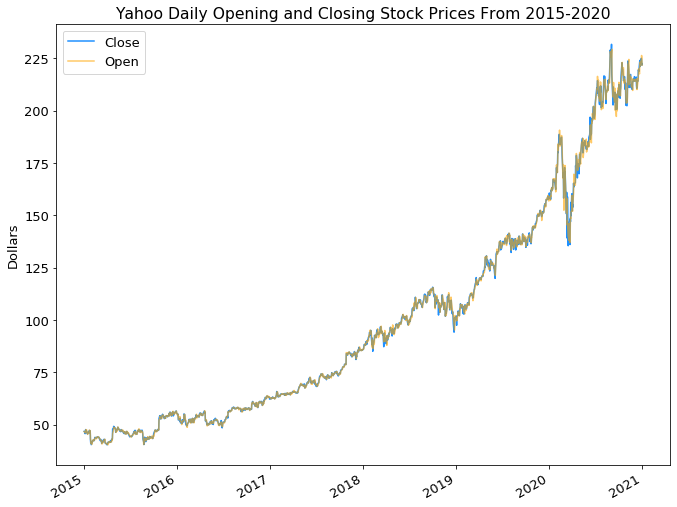

In [19]:
# Here I'm plotting two different columns from a dataframe to compare.

df.Close.plot(color='dodgerblue')
df.Open.plot(color='orange', alpha=.6)

plt.title('Yahoo Daily Opening and Closing Stock Prices From 2015-2020')
plt.xlabel('')
plt.ylabel('Dollars')
plt.legend()

plt.show()

In [20]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000
mean,100.747439,98.766486,99.781615,99.812541,3.055124e+07,96.453268
std,52.513550,51.188401,51.872945,51.881844,1.483760e+07,52.994541
min,40.740002,39.720001,40.340000,40.290001,7.425600e+06,35.806782
25%,56.049999,55.160000,55.680000,55.740000,2.143080e+07,50.865084
50%,87.089996,85.500000,86.300003,86.349998,2.695970e+07,82.576843
75%,136.320000,133.575005,134.995003,135.349998,3.474365e+07,132.855774
max,232.860001,227.350006,229.270004,231.649994,1.691640e+08,230.514191


**When you have time, this tutorial plays with DataReader [more](https://www.youtube.com/watch?v=UFuo7EHI8zc&list=PL-osiE80TeTsWmV9i9c58mdDCSskIFdDS&index=10).**

<hr style="border-top: 10px groove cornflowerblue; margin-top: 1px; margin-bottom: 1px"></hr>

## Preparing

<hr style="border-top: 10px groove cornflowerblue; margin-top: 1px; margin-bottom: 1px"></hr>

### **<font color=red>What?</font>**

I will address specifically preparing data with a DatetimeIndex. Click [here](#conversion) to jump back up to how to convert your DataFrame or import your csv file to have a DatetimeIndex.

___

### **<font color=orange>So What?</font>**

Time series data allows us to forecast and plan for future events and patterns by analyzing and understanding past events and patterns even when time is our only known variable.

**<font color=purple>Important Components of Time Series Data</font>**

**Trend** is the upward or downward movement of a value over time. (Uptrend or Downtrend)

>For example, the cost of living in San Antonio is on an Uptrend while compensation has not increased at the same rate.

**Seasonality** is a repeating pattern that occurs over a fixed time frame like a day, a week, a month, etc.

>For example, if you look at the number of cars on the road, you will see seasonality as the number of cars increases or decreases at certain times of the day.

___

### **<font color=green>Now What?</font>**

<div class="alert alert-block alert-danger"> If you have upgraded to pandas 1.0.3,</div>

You can check by running this in a cell `pd.__version__`,[this documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html#pandas.DatetimeIndex) will be helpful.

In [46]:
pd.__version__

'1.0.3'

In [21]:
# I'll use the flights dataset from vega_datasets converted to have a DateTimeIndex.

from vega_datasets import data

fdf = data.flights_20k()
fdf = fdf.set_index('date').sort_index()

fdf.head(2)

,delay,distance,origin,destination
date,,,,
2001-01-01 00:01:00,14,405,MCI,MDW
2001-01-01 06:20:00,0,491,BNA,MCI


In [22]:
# I can use the .min() method on the index of my df to return the first date in my dataset.

fdf.index.min()

Timestamp('2001-01-01 00:01:00')

In [23]:
# I can use the .max() method on the index of my df to return the last date in my dataset.

fdf.index.max()

Timestamp('2001-03-31 21:30:00')

___

#### Use `.loc()`

**I can use `.loc[]` to access a row or column or a group of rows or colums by index label, which in this case is a date.**

I can pass in my results from calling `fdf.index.min()` and `fdf.index.max()` above. I get back all of the information for the first observation in my dataset and the last.

In [24]:
# There is only one observation that matches this date and time combo, so I get back a Series.

fdf.loc[fdf.index.min()]

delay           14
distance       405
origin         MCI
destination    MDW
Name: 2001-01-01 00:01:00, dtype: object

In [25]:
# There are two observations with this date and time combo, so I get back a DataFrame.

fdf.loc[fdf.index.max()]

,delay,distance,origin,destination
date,,,,
2001-03-31 21:30:00,30,174,TPA,PBI
2001-03-31 21:30:00,-11,495,BWI,SDF


In [26]:
# I can look at all of the observations from a specific date passed to `.loc[]`.

fdf.loc['2001-02-03'].head()

,delay,distance,origin,destination
date,,,,
2001-02-03 06:20:00,-2,303,HOU,MSY
2001-02-03 06:25:00,8,689,SLC,SEA
2001-02-03 06:30:00,-1,570,BHM,HOU
2001-02-03 06:30:00,-11,677,ABQ,LAX
2001-02-03 06:30:00,0,399,BOI,SEA


In [27]:
# I can look at all of the observations from a specific date range to `.loc[]`.

fdf.loc['2001-02-03' : '2001-02-05'].head()

,delay,distance,origin,destination
date,,,,
2001-02-03 06:20:00,-2,303,HOU,MSY
2001-02-03 06:25:00,8,689,SLC,SEA
2001-02-03 06:30:00,-1,570,BHM,HOU
2001-02-03 06:30:00,-11,677,ABQ,LAX
2001-02-03 06:30:00,0,399,BOI,SEA


In [28]:
# I can look at all of the observations from a month and year combo passed to `.loc[]`.

fdf.loc['2001-01'].head()

,delay,distance,origin,destination
date,,,,
2001-01-01 00:01:00,14,405,MCI,MDW
2001-01-01 06:20:00,0,491,BNA,MCI
2001-01-01 06:30:00,-8,251,MDW,STL
2001-01-01 07:00:00,-10,361,OAK,ONT
2001-01-01 07:00:00,0,303,MSY,HOU


___

#### Use Date Parts

A DatetimeIndex allows me to quickly access and isolate other information about a particular datetime like the month, the day of the week, or the year. There are many more attributes of a timestamp object that you can access [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html#pandas.DatetimeIndex).

In [29]:
# Create new columns in my flights df by accessing different attributes of our DatetimeIndex

fdf['year'] = fdf.index.year.astype('category')
fdf['month'] = fdf.index.month.astype('category')
fdf['weekday'] = fdf.index.day_name().astype('category')

fdf.head(2)

,delay,distance,origin,destination,year,month,weekday
date,,,,,,,
2001-01-01 00:01:00,14,405,MCI,MDW,2001,1,Monday
2001-01-01 06:20:00,0,491,BNA,MCI,2001,1,Monday


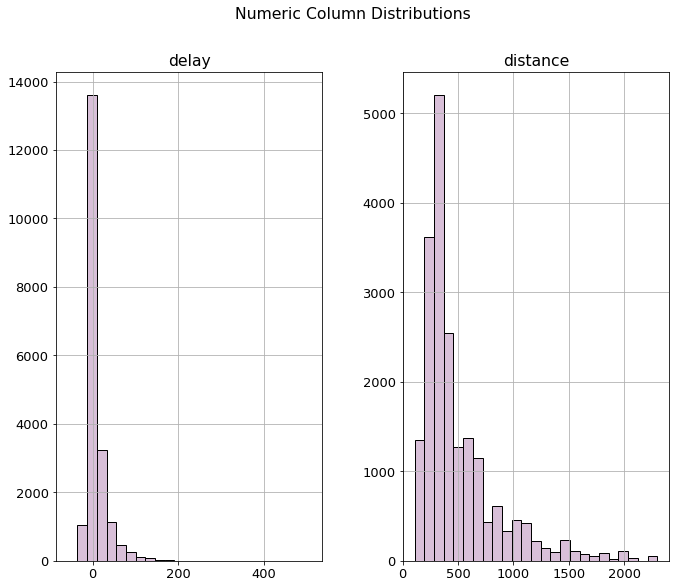

In [48]:
# I'm using my own created function here to check out distributions of just my numeric columns.
numeric_hists(fdf, bins=25)

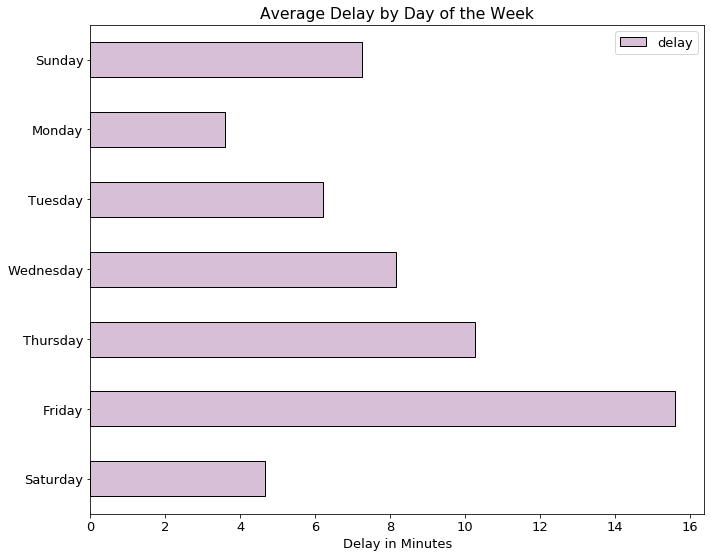

In [49]:
# Visualize delay by day of the week

cats = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fdf.groupby('weekday')[['delay']].mean().reindex(cats).plot(kind='barh', 
                                                            color='thistle', 
                                                            ec='black')
plt.title('Average Delay by Day of the Week')
plt.ylabel('')
plt.xlabel('Delay in Minutes')

# Invert the y-axis to start on Sunday
plt.gca().invert_yaxis()
plt.show()

####  Use `.assign()` 
**Create New Columns from existing columns in your df**

```python
df = df.assign(new_col_name = your calculation)
```

In [32]:
# Let's use our Microsoft df again.

df = web.DataReader(name='MSFT', data_source='yahoo', start = '2015-01-01', end='2020-12-31').sort_index()
df.head(2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,41.443684
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,41.062580


In [33]:
# I can create a new calculated column from two existing columns in my DataFrame using `.assign()`.

df = df.assign(Price_range = df.High - df.Low)
df.head(1)

,High,Low,Open,Close,Volume,Adj Close,Price_range
Date,,,,,,,
2015-01-02,47.419998,46.540001,46.66,46.759998,27913900.0,41.443684,0.879997


#### Use `.diff()`

**Using `.diff()` calculates the difference of a df element compared with another element in the df (the default is the element in the previous row of the same column).**

    {default}
```python
df.diff(periods=1, axis=0)
```

**Difference in df element with df element in previous rows**
```python
df.diff()
```

**Difference in df element with df element in previous columns**
```python
df.diff(axis=1)
```

Here I create a new calculated column using `.assign()` with the value of the difference between current sales and previous day sales. Each observation represents a single business day.

In [34]:
df = df.assign(Price_range_diff = df.Price_range.diff())
df.head(5)

,High,Low,Open,Close,Volume,Adj Close,Price_range,Price_range_diff
Date,,,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,41.443684,0.879997,NaN
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,41.062580,0.480000,-0.399998
2015-01-06,46.750000,45.540001,46.380001,45.650002,36447900.0,40.459892,1.209999,0.730000
2015-01-07,46.459999,45.490002,45.980000,46.230000,29114100.0,40.973934,0.969997,-0.240002
2015-01-08,47.750000,46.720001,46.750000,47.590000,29645200.0,42.179317,1.029999,0.060001


___

#### Use `.resample()`

Using `df.resample()` is similar to a `df.groupby()` operation, but with `df.resample()` I end up aggregating with a time frequency.

- **rule:** {DateOffset, Timedelta or str}
   
- **axis:** {0 or ‘index’, 1 or ‘columns’}, default 0

```python
df.resample(rule='D', axis=0)
```

<table style="display: inline-block">
    <caption style="text-align: center"><strong>TIME SERIES OFFSET ALIASES</strong></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>B</td><td>business day frequency</td></tr>
<tr><td>C</td><td>custom business day frequency (experimental)</td></tr>
<tr><td>D</td><td>calendar day frequency</td></tr>
<tr><td>W</td><td>weekly frequency</td></tr>
<tr><td>M</td><td>month end frequency</td></tr>
<tr><td>SM</td><td>semi-month end frequency (15th and end of month)</td></tr>
<tr><td>BM</td><td>business month end frequency</td></tr>
<tr><td>CBM</td><td>custom business month end frequency</td></tr>
<tr><td>MS</td><td>month start frequency</td></tr>
<tr><td>SMS</td><td>semi-month start frequency (1st and 15th)</td></tr>
<tr><td>BMS</td><td>business month start frequency</td></tr>
<tr><td>CBMS</td><td>custom business month start frequency</td></tr>
<tr><td>Q</td><td>quarter end frequency</td></tr>
<tr><td></td><td><font color=white>intentionally left blank</font></td></tr></table>

<table style="display: inline-block; margin-left: 40px">
<caption style="text-align: center"></caption>
<tr><th>ALIAS</th><th>DESCRIPTION</th></tr>
<tr><td>BQ</td><td>business quarter endfrequency</td></tr>
<tr><td>QS</td><td>quarter start frequency</td></tr>
<tr><td>BQS</td><td>business quarter start frequency</td></tr>
<tr><td>A</td><td>year end frequency</td></tr>
<tr><td>BA</td><td>business year end frequency</td></tr>
<tr><td>AS</td><td>year start frequency</td></tr>
<tr><td>BAS</td><td>business year start frequency</td></tr>
<tr><td>BH</td><td>business hour frequency</td></tr>
<tr><td>H</td><td>hourly frequency</td></tr>
<tr><td>T, min</td><td>minutely frequency</td></tr>
<tr><td>S</td><td>secondly frequency</td></tr>
<tr><td>L, ms</td><td>milliseconds</td></tr>
<tr><td>U, us</td><td>microseconds</td></tr>
<tr><td>N</td><td>nanoseconds</td></tr></table>

In [35]:
# Here I resample my df by month and aggregate the differences in `Price_range_diff` using `.sum()`.
    
df.resample('M').Price_range_diff.sum().head()

Date
2015-01-31    0.350006
2015-02-28   -0.690002
2015-03-31   -0.050003
2015-04-30    0.450005
2015-05-31    0.039997
Freq: M, Name: Price_range_diff, dtype: float64

How about a quick look at that resample...It looks like the total monthly rise and fall of MS stock prices.

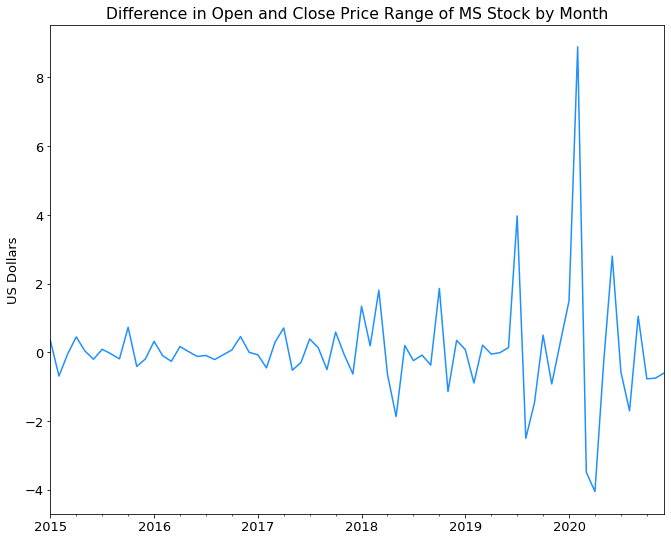

In [36]:
df.resample('M').Price_range_diff.sum().plot(color='dodgerblue')

plt.title('Difference in Open and Close Price Range of MS Stock by Month')
plt.xlabel('')
plt.ylabel('US Dollars')

plt.show()

**You can also use `.resample()` with your own custom function using `.apply()`.**

```python
df.resample(rule='A').apply(my_func)
```

___

#### Use `.shift()`

Using `df.shift()` shifts all of the data points for the columns forward or backward by 1 period or increment by default.

**Note:** When you shift one period without specifying a frequeny increment, the index will shift by its own frequency attribute, and you will lose the first or last value(s) that shifts beyond the date bounds of your df.

```python
# These are the default setting for the parameters.

df.shift(periods=1, freq=None, axis=0, fill_value=None) -> 'DataFrame'
```
**Note:** If `freq` is specified then the index values are shifted but the data is not realigned. That is, use `freq` if you would like to extend the index when shifting and preserve the original data. (from the doc)

In [37]:
# I can shift foward by one day; note the first row is now NaN.

df.shift(1).head()

,High,Low,Open,Close,Volume,Adj Close,Price_range,Price_range_diff
Date,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,47.419998,46.540001,46.660000,46.759998,27913900.0,41.443684,0.879997,NaN
2015-01-06,46.730000,46.250000,46.369999,46.330002,39673900.0,41.062580,0.480000,-0.399998
2015-01-07,46.750000,45.540001,46.380001,45.650002,36447900.0,40.459892,1.209999,0.730000
2015-01-08,46.459999,45.490002,45.980000,46.230000,29114100.0,40.973934,0.969997,-0.240002


```python
df.shift(periods=-1)
```

In [38]:
# I can shift backwards by one day; note the last row is now NaN.

df.shift(-1).tail()

,High,Low,Open,Close,Volume,Adj Close,Price_range,Price_range_diff
Date,,,,,,,,
2020-12-24,226.029999,223.020004,224.449997,224.960007,17933500.0,224.443069,3.009995,0.599991
2020-12-28,227.179993,223.580002,226.309998,224.149994,17403200.0,223.634918,3.599991,0.589996
2020-12-29,225.630005,221.470001,225.229996,221.679993,20272300.0,221.170593,4.160004,0.560013
2020-12-30,223.000000,219.679993,221.699997,222.419998,20942100.0,221.908905,3.320007,-0.839996
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# I can shift my index such that each observation is dated the 1st of each month.

df.shift(freq='MS').head()

,High,Low,Open,Close,Volume,Adj Close,Price_range,Price_range_diff
Date,,,,,,,,
2015-02-01,47.419998,46.540001,46.660000,46.759998,27913900.0,41.443684,0.879997,NaN
2015-02-01,46.730000,46.250000,46.369999,46.330002,39673900.0,41.062580,0.480000,-0.399998
2015-02-01,46.750000,45.540001,46.380001,45.650002,36447900.0,40.459892,1.209999,0.730000
2015-02-01,46.459999,45.490002,45.980000,46.230000,29114100.0,40.973934,0.969997,-0.240002
2015-02-01,47.750000,46.720001,46.750000,47.590000,29645200.0,42.179317,1.029999,0.060001


In [40]:
# I can then groupby month and calculate the average values for each month.

df.shift(freq='MS').groupby('Date').mean().head()

,High,Low,Open,Close,Volume,Adj Close,Price_range,Price_range_diff
Date,,,,,,,,
2015-02-01,46.071000,45.032000,45.639000,45.514000,4.594834e+07,40.339348,1.039000,0.018421
2015-03-01,43.272632,42.671052,42.996843,43.078421,3.455314e+07,38.311680,0.601579,-0.036316
2015-04-01,42.528182,41.848182,42.140000,42.131818,3.746979e+07,37.607446,0.680000,-0.002273
2015-05-01,43.736667,42.870952,43.071905,43.466666,4.164454e+07,38.798950,0.865714,0.021429
2015-06-01,47.977000,47.185500,47.587000,47.530000,3.165364e+07,42.535575,0.791500,0.002000


___

#### Use `df.rolling()`

**Using `df.rolling()` allows you to create a moving window of time and perform some type of aggregate function on your column(s) or df.**

```python
df.rolling(
    window,
    min_periods=None,
    center=False,
    win_type=None,
    on=None,
    axis=0,
    closed=None)
```

In [41]:
# Examine a 7-day rolling average on our entire df. Notice the NaN values until observation 7.

df.rolling(7).mean().head(10)

,High,Low,Open,Close,Volume,Adj Close,Price_range,Price_range_diff
Date,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,47.210000,46.257144,46.738571,46.621428,3.005587e+07,41.320869,0.952856,NaN
2015-01-13,47.280000,46.188572,46.782857,46.564286,3.110683e+07,41.270224,1.091427,0.138572
2015-01-14,47.210000,46.098572,46.724286,46.511428,2.968479e+07,41.223376,1.111428,0.020000


In [42]:
# Create a column for a 7-day rolling average Price Range and and 30-day rolling average for Close

df = df.assign(Rolling_7_price_range = df.Price_range.rolling(7).mean())
df = df.assign(Rolling_30_close = df.Close.rolling(30).mean())
df.head(7)

,High,Low,Open,Close,Volume,Adj Close,Price_range,Price_range_diff,Rolling_7_price_range,Rolling_30_close
Date,,,,,,,,,,
2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,41.443684,0.879997,NaN,NaN,NaN
2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,41.062580,0.480000,-0.399998,NaN,NaN
2015-01-06,46.750000,45.540001,46.380001,45.650002,36447900.0,40.459892,1.209999,0.730000,NaN,NaN
2015-01-07,46.459999,45.490002,45.980000,46.230000,29114100.0,40.973934,0.969997,-0.240002,NaN,NaN
2015-01-08,47.750000,46.720001,46.750000,47.590000,29645200.0,42.179317,1.029999,0.060001,NaN,NaN
2015-01-09,47.820000,46.900002,47.610001,47.189999,23944200.0,41.824806,0.919998,-0.110001,NaN,NaN
2015-01-12,47.540001,46.360001,47.419998,46.599998,23651900.0,41.301872,1.180000,0.260002,0.952856,NaN


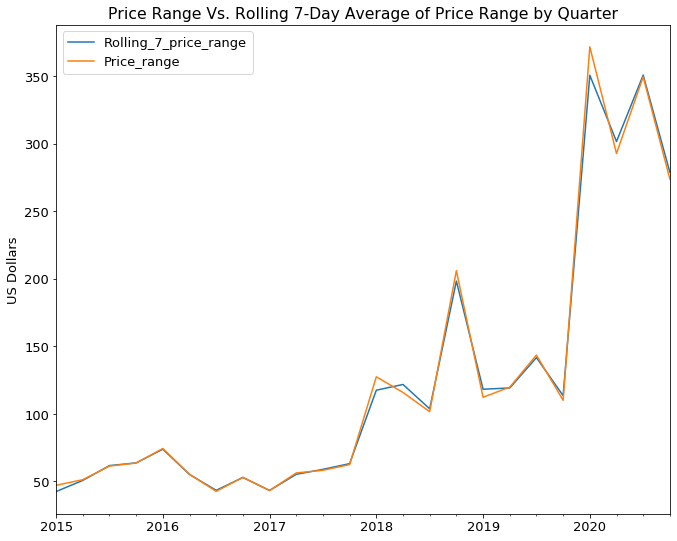

In [43]:
# Plot Price_range against the 7-day rolling avg Price_range by quarter

df.resample('Q').sum()[['Rolling_7_price_range', 'Price_range']].plot()

plt.title('Price Range Vs. Rolling 7-Day Average of Price Range by Quarter')
plt.xlabel('')
plt.ylabel('US Dollars')

plt.show()

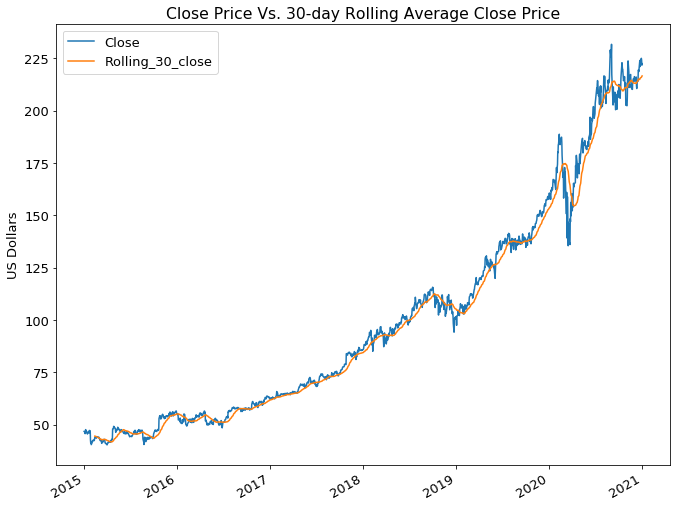

In [44]:
df[['Close', 'Rolling_30_close']].plot()

plt.title('Close Price Vs. 30-day Rolling Average Close Price')
plt.xlabel('')
plt.ylabel('US Dollars')

plt.show()

___

#### Use `.expand()`

Using `df[col].expand()` allows me to create an exapanding window that considers all of the values that come before that point in time. Here I create an expanding window for Close price; the top right is the overall sum of the Close price for the df.


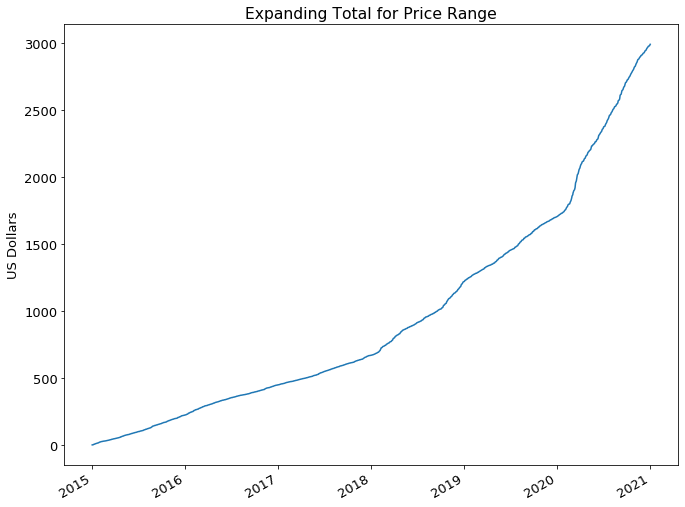

In [45]:
df['Price_range'].expanding().sum().plot()

plt.title('Expanding Total for Price Range')
plt.xlabel('')
plt.ylabel('US Dollars')

plt.show()